In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from utilities import UberAll, UberBartMix, Drive

# Load the GeoJSON data
neighborhoods = gpd.read_file("Demographics_By_Census_Tract.geojson")

# Preprocessing
latitude_miles_per_degree = 69
longitude_miles_per_degree = 55.2
berryessa_station = Point(-121.8746, 37.3684)  # Berryessa coordinates (lon, lat)
neighborhoods['centroid'] = neighborhoods.geometry.centroid
neighborhoods['distance_to_berryessa_deg'] = neighborhoods['centroid'].distance(berryessa_station)
neighborhoods['distance_to_berryessa_miles'] = neighborhoods['distance_to_berryessa_deg'] * (
    latitude_miles_per_degree**2 + longitude_miles_per_degree**2)**0.5
neighborhoods['population'] = neighborhoods['POPTOTAL'] if 'POPTOTAL' in neighborhoods else 1000

# Constants for calculations
subsidy_levels = np.arange(0, 8.01, 0.01)  # Subsidy from 0 to 8 with step 0.01
revenue_increases = []
total_rides_no_sub = 30251
time_to_money_conversion = 25
car_pc = 0.5
safety_cost = 20
hour_of_day = 17
inconvenience_fee = 30
is_weekday = True
beta = 0.3
total_population = neighborhoods['population'].sum()

# Initialize transportation cost objects
ua = UberAll(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'])
ub = UberBartMix(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'], safety_cost)
neighborhoods['cost_uber_all'] = ua.get_cost(hour_of_day, is_weekday)
# neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
neighborhoods['cost_bart_uber_no_subsidy'] = ub.get_cost() 
neighborhoods['cost_drive'] = Drive(time_to_money_conversion, inconvenience_fee).get_cost(hour_of_day, is_weekday)

beta = 0.3 # emperically chosen it produces a reasonable logistic function
exp_bart_uber_no_subsidy = np.exp(-beta * neighborhoods['cost_bart_uber_no_subsidy'])
exp_uber_all = np.exp(-beta * neighborhoods['cost_uber_all'])
# for people without car

total_exp_without_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all

# for people with car
exp_drive = np.exp(-beta * neighborhoods['cost_drive'])
total_exp_with_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all + exp_drive

# neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) 
neighborhoods['percent_choosing_bart_no_subsidy'] = (exp_bart_uber_no_subsidy / total_exp_without_car_nosub) * (1-car_pc) + (exp_bart_uber_no_subsidy / total_exp_with_car_nosub) * car_pc


average_percent_without_subsidy = (
    (neighborhoods['percent_choosing_bart_no_subsidy'] * neighborhoods['population']).sum()
    / total_population * 100
)

# Subsidy sweep
for subsidy in subsidy_levels:

    neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    exp_bart_uber_mix = np.exp(-beta * neighborhoods['cost_bart_uber'])
    total_exp_without_car = exp_bart_uber_mix + exp_uber_all
    total_exp_with_car = exp_bart_uber_mix + exp_uber_all + exp_drive
    neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) * (1 - car_pc) + (exp_bart_uber_mix / total_exp_with_car) * car_pc
    average_percent_with_subsidy = (
        (neighborhoods['percent_choosing_bart'] * neighborhoods['population']).sum()
        / total_population * 100
    )
    total_rides = total_rides_no_sub * (1 + (average_percent_with_subsidy / 100 - average_percent_without_subsidy / 100) / (average_percent_without_subsidy / 100))
    increased_ridership = total_rides - total_rides_no_sub
    increased_revenue = (7.2 - subsidy) * increased_ridership
    revenue_increases.append(increased_revenue)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(subsidy_levels, revenue_increases, label="Revenue Increase", color="blue")
plt.title("Revenue Increase vs. Subsidy Levels at 5PM", fontsize=16)
plt.xlabel("Subsidy Level ($)", fontsize=12)
plt.ylabel("Revenue Increase ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()
max_revenue_increase = max(revenue_increases)
optimal_subsidy = subsidy_levels[np.argmax(revenue_increases)]

# Print the results
print(f"The subsidy level that produces the maximum revenue increase is ${optimal_subsidy:.2f}")
print(f"The maximum revenue increase is ${max_revenue_increase:.2f}")

ModuleNotFoundError: No module named 'matplotlib'

In [8]:
hour_of_day = 5

# Load the GeoJSON data
neighborhoods = gpd.read_file("Demographics_By_Census_Tract.geojson")

# Preprocessing
latitude_miles_per_degree = 69
longitude_miles_per_degree = 55.2
berryessa_station = Point(-121.8746, 37.3684)  # Berryessa coordinates (lon, lat)
neighborhoods['centroid'] = neighborhoods.geometry.centroid
neighborhoods['distance_to_berryessa_deg'] = neighborhoods['centroid'].distance(berryessa_station)
neighborhoods['distance_to_berryessa_miles'] = neighborhoods['distance_to_berryessa_deg'] * (
    latitude_miles_per_degree**2 + longitude_miles_per_degree**2)**0.5
neighborhoods['population'] = neighborhoods['POPTOTAL'] if 'POPTOTAL' in neighborhoods else 1000

# Constants for calculations
subsidy_levels = np.arange(0, 8.01, 0.01)  # Subsidy from 0 to 8 with step 0.01
revenue_increases = []
total_rides_no_sub = 30251
time_to_money_conversion = 25
car_pc = 0.5
safety_cost = 20

inconvenience_fee = 30
is_weekday = True
beta = 0.3
total_population = neighborhoods['population'].sum()

# Initialize transportation cost objects
ua = UberAll(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'])
ub = UberBartMix(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'], safety_cost)
neighborhoods['cost_uber_all'] = ua.get_cost(hour_of_day, is_weekday)
# neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
neighborhoods['cost_bart_uber_no_subsidy'] = ub.get_cost() 
neighborhoods['cost_drive'] = Drive(time_to_money_conversion, inconvenience_fee, neighborhoods['distance_to_berryessa_miles']).get_cost(hour_of_day, is_weekday)

beta = 0.3 # emperically chosen it produces a reasonable logistic function
exp_bart_uber_no_subsidy = np.exp(-beta * neighborhoods['cost_bart_uber_no_subsidy'])
exp_uber_all = np.exp(-beta * neighborhoods['cost_uber_all'])
# for people without car

total_exp_without_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all

# for people with car
exp_drive = np.exp(-beta * neighborhoods['cost_drive'])
total_exp_with_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all + exp_drive

# neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) 
neighborhoods['percent_choosing_bart_no_subsidy'] = (exp_bart_uber_no_subsidy / total_exp_without_car_nosub) * (1-car_pc) + (exp_bart_uber_no_subsidy / total_exp_with_car_nosub) * car_pc


average_percent_without_subsidy = (
    (neighborhoods['percent_choosing_bart_no_subsidy'] * neighborhoods['population']).sum()
    / total_population * 100
)

# Subsidy sweep
for subsidy in subsidy_levels:

    neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    exp_bart_uber_mix = np.exp(-beta * neighborhoods['cost_bart_uber'])
    total_exp_without_car = exp_bart_uber_mix + exp_uber_all
    total_exp_with_car = exp_bart_uber_mix + exp_uber_all + exp_drive
    neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) * (1 - car_pc) + (exp_bart_uber_mix / total_exp_with_car) * car_pc
    average_percent_with_subsidy = (
        (neighborhoods['percent_choosing_bart'] * neighborhoods['population']).sum()
        / total_population * 100
    )
    total_rides = total_rides_no_sub * (1 + (average_percent_with_subsidy / 100 - average_percent_without_subsidy / 100) / (average_percent_without_subsidy / 100))
    increased_ridership = total_rides - total_rides_no_sub
    increased_revenue = (7.2 - subsidy) * increased_ridership
    revenue_increases.append(increased_revenue)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(subsidy_levels, revenue_increases, label="Revenue Increase", color="blue")
plt.title("Revenue Increase vs. Subsidy Levels at 5AM", fontsize=16)
plt.xlabel("Subsidy Level ($)", fontsize=12)
plt.ylabel("Revenue Increase ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()
max_revenue_increase = max(revenue_increases)
optimal_subsidy = subsidy_levels[np.argmax(revenue_increases)]

# Print the results
print(f"The subsidy level that produces the maximum revenue increase is ${optimal_subsidy:.2f}")
print(f"The maximum revenue increase is ${max_revenue_increase:.2f}")

AttributeError: module 'fiona' has no attribute 'path'

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from utilities import UberAll, UberBartMix, Drive

# Load the GeoJSON data
neighborhoods = gpd.read_file("Demographics_By_Census_Tract.geojson")

# Preprocessing
latitude_miles_per_degree = 69
longitude_miles_per_degree = 55.2
berryessa_station = Point(-121.8746, 37.3684)  # Berryessa coordinates (lon, lat)
neighborhoods['centroid'] = neighborhoods.geometry.centroid
neighborhoods['distance_to_berryessa_deg'] = neighborhoods['centroid'].distance(berryessa_station)
neighborhoods['distance_to_berryessa_miles'] = neighborhoods['distance_to_berryessa_deg'] * (latitude_miles_per_degree**2 + longitude_miles_per_degree**2)**0.5
neighborhoods['population'] = neighborhoods['POPTOTAL'] if 'POPTOTAL' in neighborhoods else 1000

# Constants for calculations
subsidy = 4  # Subsidy from 0 to 8 with step 0.01
revenue_increases = []
total_rides_no_sub = 30251
time_to_money_conversion = 25
car_pc = 0.5
safety_cost = 20
hours_of_day = np.arange(5, 21.1, 1)
inconvenience_fee = 30
is_weekday = True
beta = 0.3
total_population = neighborhoods['population'].sum()
# hours sweep
for hour_of_day in hours_of_day:
    ua = UberAll(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'])
    ub = UberBartMix(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'], safety_cost)
    neighborhoods['cost_uber_all'] = ua.get_cost(hour_of_day, is_weekday)
    # neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    neighborhoods['cost_bart_uber_no_subsidy'] = ub.get_cost() 
    neighborhoods['cost_drive'] = Drive(time_to_money_conversion, inconvenience_fee).get_cost(hour_of_day, is_weekday)

    beta = 0.3 # emperically chosen it produces a reasonable logistic function
    exp_bart_uber_no_subsidy = np.exp(-beta * neighborhoods['cost_bart_uber_no_subsidy'])
    exp_uber_all = np.exp(-beta * neighborhoods['cost_uber_all'])
    exp_drive = np.exp(-beta * neighborhoods['cost_drive'])

    # neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) 


    
    subsidy = 4
    neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    exp_bart_uber_mix = np.exp(-beta * neighborhoods['cost_bart_uber'])
    total_exp_without_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all
    total_exp_with_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all + exp_drive
    total_exp_without_car = exp_bart_uber_mix + exp_uber_all
    total_exp_with_car = exp_bart_uber_mix + exp_uber_all + exp_drive
    neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) * (1 - car_pc) + (exp_bart_uber_mix / total_exp_with_car) * car_pc
    neighborhoods['percent_choosing_bart_no_subsidy'] = (exp_bart_uber_no_subsidy / total_exp_without_car_nosub) * (1-car_pc) + (exp_bart_uber_no_subsidy / total_exp_with_car_nosub) * car_pc
    average_percent_without_subsidy = (
            (neighborhoods['percent_choosing_bart_no_subsidy'] * neighborhoods['population']).sum()
            / total_population * 100
        )
    average_percent_with_subsidy = (
        (neighborhoods['percent_choosing_bart'] * neighborhoods['population']).sum()
        / total_population * 100
    )
    total_rides = total_rides_no_sub * (1 + (average_percent_with_subsidy / 100 - average_percent_without_subsidy / 100) / (average_percent_without_subsidy / 100))

    increased_ridership = total_rides - total_rides_no_sub
    increased_revenue = (7.2 - subsidy) * increased_ridership
    print(average_percent_with_subsidy, average_percent_without_subsidy)
    print(increased_ridership)
    revenue_increases.append(increased_revenue)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(hours_of_day, revenue_increases, label="Revenue Increase", color="blue")
plt.title("Revenue Increase vs. Hour in Day on Weekdays", fontsize=16)
plt.xlabel("Hour in Day", fontsize=12)
plt.ylabel("Revenue Increase ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()
max_revenue_increase = max(revenue_increases)
optimal_subsidy = hours_of_day[np.argmax(revenue_increases)]
print(revenue_increases)
# Print the results
print(f"The best hour is {optimal_subsidy:.2f}")
print(f"The maximum revenue increase is ${max_revenue_increase:.2f}")

AttributeError: module 'fiona' has no attribute 'path'

13.927715125269607 7.997076986401535
1794.0773433889808
14.893212258755288 8.772046287292659
1851.7139180271552
15.806757890506859 9.523625360340764
1900.7104217005399
16.983714828288292 10.516834155174786
1956.2960724235636
18.044230624232892 11.434809724124259
1999.4159164918674
18.624840891101094 11.945959776974423
2020.4283258344658
19.093786286481716 12.362949679798405
2036.1453818877708
19.8270614856176 13.023472514281998
2058.153699718736
21.204612701111433 14.291953157170692
2091.148638637511
24.367892489971325 17.33722466028532
2126.84732515832
29.00083750631127 22.146800389130227
2073.4147683184456
33.24204161377233 27.001553020981618
1887.8102042051178
35.81370805838981 30.22511963680234
1690.6038834144274
36.28787849063399 30.84952215903155
1645.15717387306
34.923011679467145 29.0904012061947
1764.4229942696438
31.730909606705815 25.22531202273632
1968.0083251266115
26.662157130952814 19.67486090962411
2113.726979914143


/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/array.py:334: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  self.crs = crs
/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/geodataframe.py:409: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  level.crs = crs


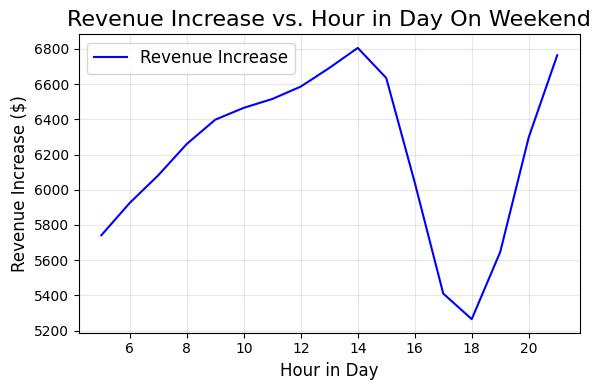

[np.float64(5741.047498844739), np.float64(5925.484537686897), np.float64(6082.273349441728), np.float64(6260.147431755404), np.float64(6398.130932773976), np.float64(6465.370642670291), np.float64(6515.665222040867), np.float64(6586.091839099955), np.float64(6691.675643640036), np.float64(6805.911440506625), np.float64(6634.927258619026), np.float64(6040.992653456377), np.float64(5409.932426926168), np.float64(5264.502956393792), np.float64(5646.15358166286), np.float64(6297.626640405157), np.float64(6763.9263357252585)]
The best hour is 14.00
The maximum revenue increase is $6805.91


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from utilities import UberAll, UberBartMix, Drive

# Load the GeoJSON data
neighborhoods = gpd.read_file("Demographics_By_Census_Tract.geojson")

# Preprocessing
latitude_miles_per_degree = 69
longitude_miles_per_degree = 55.2
berryessa_station = Point(-121.8746, 37.3684)  # Berryessa coordinates (lon, lat)
neighborhoods['centroid'] = neighborhoods.geometry.centroid
neighborhoods['distance_to_berryessa_deg'] = neighborhoods['centroid'].distance(berryessa_station)
neighborhoods['distance_to_berryessa_miles'] = neighborhoods['distance_to_berryessa_deg'] * (latitude_miles_per_degree**2 + longitude_miles_per_degree**2)**0.5
neighborhoods['population'] = neighborhoods['POPTOTAL'] if 'POPTOTAL' in neighborhoods else 1000

# Constants for calculations
subsidy = 4  # Subsidy from 0 to 8 with step 0.01
revenue_increases = []
total_rides_no_sub = 30251
time_to_money_conversion = 25
car_pc = 0.5
safety_cost = 20
hours_of_day = np.arange(5, 21.1, 1)
inconvenience_fee = 30
is_weekday = False
beta = 0.3
total_population = neighborhoods['population'].sum()
# hours sweep
for hour_of_day in hours_of_day:
    ua = UberAll(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'])
    ub = UberBartMix(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'], safety_cost)
    neighborhoods['cost_uber_all'] = ua.get_cost(hour_of_day, is_weekday)
    # neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    neighborhoods['cost_bart_uber_no_subsidy'] = ub.get_cost() 
    neighborhoods['cost_drive'] = Drive(time_to_money_conversion, inconvenience_fee).get_cost(hour_of_day, is_weekday)

    beta = 0.3 # emperically chosen it produces a reasonable logistic function
    exp_bart_uber_no_subsidy = np.exp(-beta * neighborhoods['cost_bart_uber_no_subsidy'])
    exp_uber_all = np.exp(-beta * neighborhoods['cost_uber_all'])
    exp_drive = np.exp(-beta * neighborhoods['cost_drive'])

    # neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) 


    
    subsidy = 4
    neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    exp_bart_uber_mix = np.exp(-beta * neighborhoods['cost_bart_uber'])
    total_exp_without_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all
    total_exp_with_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all + exp_drive
    total_exp_without_car = exp_bart_uber_mix + exp_uber_all
    total_exp_with_car = exp_bart_uber_mix + exp_uber_all + exp_drive
    neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) * (1 - car_pc) + (exp_bart_uber_mix / total_exp_with_car) * car_pc
    neighborhoods['percent_choosing_bart_no_subsidy'] = (exp_bart_uber_no_subsidy / total_exp_without_car_nosub) * (1-car_pc) + (exp_bart_uber_no_subsidy / total_exp_with_car_nosub) * car_pc
    average_percent_without_subsidy = (
            (neighborhoods['percent_choosing_bart_no_subsidy'] * neighborhoods['population']).sum()
            / total_population * 100
        )
    average_percent_with_subsidy = (
        (neighborhoods['percent_choosing_bart'] * neighborhoods['population']).sum()
        / total_population * 100
    )
    total_rides = total_rides_no_sub * (1 + (average_percent_with_subsidy / 100 - average_percent_without_subsidy / 100) / (average_percent_without_subsidy / 100))

    increased_ridership = total_rides - total_rides_no_sub
    increased_revenue = (7.2 - subsidy) * increased_ridership
    print(average_percent_with_subsidy, average_percent_without_subsidy)
    print(increased_ridership)
    revenue_increases.append(increased_revenue)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(hours_of_day, revenue_increases, label="Revenue Increase", color="blue")
plt.title("Revenue Increase vs. Hour in Day On Weekend", fontsize=16)
plt.xlabel("Hour in Day", fontsize=12)
plt.ylabel("Revenue Increase ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()
max_revenue_increase = max(revenue_increases)
optimal_subsidy = hours_of_day[np.argmax(revenue_increases)]
print(revenue_increases)
# Print the results
print(f"The best hour is {optimal_subsidy:.2f}")
print(f"The maximum revenue increase is ${max_revenue_increase:.2f}")

/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/array.py:334: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  self.crs = crs
/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/geodataframe.py:409: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  level.crs = crs


90.70458874768748 87.92890327294542
839.6726129642193
89.82734569604295 87.06044530442794
837.0150374674558
88.9501026443984 86.19198733591045
834.3574619706887
88.07285959275384 85.32352936739296
831.6998864739144
87.19561654110932 84.45507139887548
829.0423109771618
86.31837348946479 83.586613430358
826.3847354803984
85.44113043782022 82.71815546184051
823.7271599836204
84.56388738617568 81.84969749332302
821.0695844868569
83.68664433453115 80.98123952480555
818.4120089900935
82.80940128288663 80.11278155628806
815.75443349333
81.93215823124207 79.24432358777058
813.0968579965593
81.05491517959751 78.3758656192531
810.4392824997885
80.17767212795299 77.5074076507356
807.7817070030324
79.30042907630843 76.63894968221811
805.1241315062616
78.42318602466388 75.77049171370065
802.4665560094909
77.54594297301935 74.90203374518316
799.8089805127274
76.66869992137481 74.03357577666566
797.1514050159712
75.79145686973027 73.16511780814818
794.4938295191932
74.91421381808573 72.2966598396307


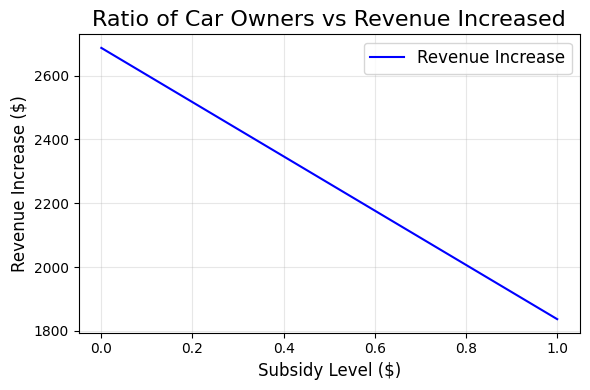

[np.float64(2686.952361485502), np.float64(2678.448119895859), np.float64(2669.943878306204), np.float64(2661.4396367165264), np.float64(2652.935395126918), np.float64(2644.431153537275), np.float64(2635.9269119475853), np.float64(2627.4226703579425), np.float64(2618.9184287682992), np.float64(2610.414187178656), np.float64(2601.90994558899), np.float64(2593.4057039993236), np.float64(2584.9014624097035), np.float64(2576.3972208200375), np.float64(2567.892979230371), np.float64(2559.388737640728), np.float64(2550.8844960511083), np.float64(2542.3802544614186), np.float64(2533.8760128717754), np.float64(2525.371771282109), np.float64(2516.867529692443), np.float64(2508.363288102823), np.float64(2499.8590465131565), np.float64(2491.3548049234905), np.float64(2482.8505633338473), np.float64(2474.3463217441576), np.float64(2465.8420801545494), np.float64(2457.337838564883), np.float64(2448.83359697524), np.float64(2440.3293553855738), np.float64(2431.825113795919), np.float64(2423.32087220

In [ ]:

# Load the GeoJSON data
neighborhoods = gpd.read_file("Demographics_By_Census_Tract.geojson")

# Preprocessing
latitude_miles_per_degree = 69
longitude_miles_per_degree = 55.2
berryessa_station = Point(-121.8746, 37.3684)  # Berryessa coordinates (lon, lat)
neighborhoods['centroid'] = neighborhoods.geometry.centroid
neighborhoods['distance_to_berryessa_deg'] = neighborhoods['centroid'].distance(berryessa_station)
neighborhoods['distance_to_berryessa_miles'] = neighborhoods['distance_to_berryessa_deg'] * (latitude_miles_per_degree**2 + longitude_miles_per_degree**2)**0.5
neighborhoods['population'] = neighborhoods['POPTOTAL'] if 'POPTOTAL' in neighborhoods else 1000

# Constants for calculations
subsidy = 4  # Subsidy from 0 to 8 with step 0.01
revenue_increases = []
total_rides_no_sub = 30251
time_to_money_conversion = 25
car_pcs = np.arange(0, 1.01, 0.01)
safety_cost = 20
hour_of_day = 17
inconvenience_fee = 30
is_weekday = True
beta = 0.3
total_population = neighborhoods['population'].sum()
# hours sweep
for car_pc in car_pcs:
    ua = UberAll(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'])
    ub = UberBartMix(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'], safety_cost)
    neighborhoods['cost_uber_all'] = ua.get_cost(hour_of_day, is_weekday)
    # neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    neighborhoods['cost_bart_uber_no_subsidy'] = ub.get_cost() 
    neighborhoods['cost_drive'] = Drive(time_to_money_conversion, inconvenience_fee).get_cost(hour_of_day, is_weekday)

    beta = 0.3 # emperically chosen it produces a reasonable logistic function
    exp_bart_uber_no_subsidy = np.exp(-beta * neighborhoods['cost_bart_uber_no_subsidy'])
    exp_uber_all = np.exp(-beta * neighborhoods['cost_uber_all'])
    exp_drive = np.exp(-beta * neighborhoods['cost_drive'])

    # neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) 


    
    subsidy = 4
    neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    exp_bart_uber_mix = np.exp(-beta * neighborhoods['cost_bart_uber'])
    total_exp_without_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all
    total_exp_with_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all + exp_drive
    total_exp_without_car = exp_bart_uber_mix + exp_uber_all
    total_exp_with_car = exp_bart_uber_mix + exp_uber_all + exp_drive
    neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) * (1 - car_pc) + (exp_bart_uber_mix / total_exp_with_car) * car_pc
    neighborhoods['percent_choosing_bart_no_subsidy'] = (exp_bart_uber_no_subsidy / total_exp_without_car_nosub) * (1-car_pc) + (exp_bart_uber_no_subsidy / total_exp_with_car_nosub) * car_pc
    average_percent_without_subsidy = (
            (neighborhoods['percent_choosing_bart_no_subsidy'] * neighborhoods['population']).sum()
            / total_population * 100
        )
    average_percent_with_subsidy = (
        (neighborhoods['percent_choosing_bart'] * neighborhoods['population']).sum()
        / total_population * 100
    )
    total_rides = total_rides_no_sub * (1 + (average_percent_with_subsidy / 100 - average_percent_without_subsidy / 100) / (average_percent_without_subsidy / 100))

    increased_ridership = total_rides - total_rides_no_sub
    increased_revenue = (7.2 - subsidy) * increased_ridership
    print(average_percent_with_subsidy, average_percent_without_subsidy)
    print(increased_ridership)
    revenue_increases.append(increased_revenue)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(car_pcs, revenue_increases, label="Revenue Increase", color="blue")
plt.title("Ratio of Car Owners vs Revenue Increased", fontsize=16)
plt.xlabel("Subsidy Level ($)", fontsize=12)
plt.ylabel("Revenue Increase ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()
max_revenue_increase = max(revenue_increases)
optimal_subsidy = car_pcs[np.argmax(revenue_increases)]
print(revenue_increases)
# Print the results
print(f"The best hour is {optimal_subsidy:.2f}")
print(f"The maximum revenue increase is ${max_revenue_increase:.2f}")

/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/array.py:334: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  self.crs = crs
/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/geodataframe.py:409: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  level.crs = crs


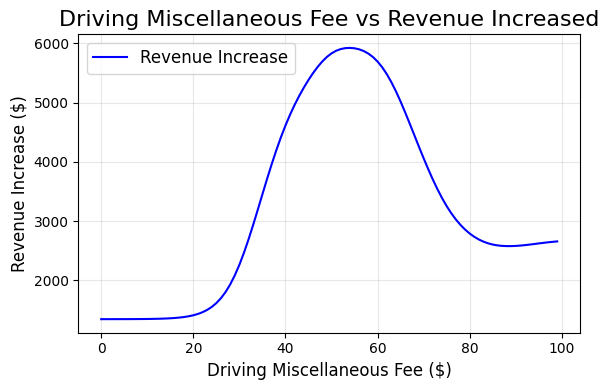

[np.float64(1343.6433630126412), np.float64(1343.701848138054), np.float64(1343.7807906368864), np.float64(1343.8873442801066), np.float64(1344.031162836752), np.float64(1344.2252724111547), np.float64(1344.4872470783187), np.float64(1344.8407923757798), np.float64(1345.3178765157588), np.float64(1345.9615958067357), np.float64(1346.8300218285062), np.float64(1348.001356931578), np.float64(1349.580825196975), np.float64(1351.7098507950084), np.float64(1354.5782246285353), np.float64(1358.4401266966715), np.float64(1363.6350360748825), np.float64(1370.6146784259706), np.float64(1379.9771449275431), np.float64(1392.509008088673), np.float64(1409.2353951931932), np.float64(1431.476158837171), np.float64(1460.902977996052), np.float64(1499.5869006163325), np.float64(1550.0183367089253), np.float64(1615.0727948706947), np.float64(1697.888924926275), np.float64(1801.6269304603688), np.float64(1929.0933339086246), np.float64(2082.257537028729), np.float64(2261.7402820028597), np.float64(2466.

In [ ]:
neighborhoods = gpd.read_file("Demographics_By_Census_Tract.geojson")

# Preprocessing
latitude_miles_per_degree = 69
longitude_miles_per_degree = 55.2
berryessa_station = Point(-121.8746, 37.3684)  # Berryessa coordinates (lon, lat)
neighborhoods['centroid'] = neighborhoods.geometry.centroid
neighborhoods['distance_to_berryessa_deg'] = neighborhoods['centroid'].distance(berryessa_station)
neighborhoods['distance_to_berryessa_miles'] = neighborhoods['distance_to_berryessa_deg'] * (latitude_miles_per_degree**2 + longitude_miles_per_degree**2)**0.5
neighborhoods['population'] = neighborhoods['POPTOTAL'] if 'POPTOTAL' in neighborhoods else 1000

# Constants for calculations
subsidy = 4  # Subsidy from 0 to 8 with step 0.01
revenue_increases = []
total_rides_no_sub = 30251
time_to_money_conversion = 25
car_pc = 0.5
safety_cost = 20
hour_of_day = 17
inconvenience_fees = np.arange(0,100,1)
is_weekday = True
beta = 0.3
total_population = neighborhoods['population'].sum()
# hours sweep
for inconvenience_fee in inconvenience_fees:
    ua = UberAll(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'])
    ub = UberBartMix(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'], safety_cost)
    neighborhoods['cost_uber_all'] = ua.get_cost(hour_of_day, is_weekday)
    # neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    neighborhoods['cost_bart_uber_no_subsidy'] = ub.get_cost() 
    neighborhoods['cost_drive'] = Drive(time_to_money_conversion, inconvenience_fee).get_cost(hour_of_day, is_weekday)

    beta = 0.3 # emperically chosen it produces a reasonable logistic function
    exp_bart_uber_no_subsidy = np.exp(-beta * neighborhoods['cost_bart_uber_no_subsidy'])
    exp_uber_all = np.exp(-beta * neighborhoods['cost_uber_all'])
    exp_drive = np.exp(-beta * neighborhoods['cost_drive'])

    # neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) 


    
    subsidy = 4
    neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    exp_bart_uber_mix = np.exp(-beta * neighborhoods['cost_bart_uber'])
    total_exp_without_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all
    total_exp_with_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all + exp_drive
    total_exp_without_car = exp_bart_uber_mix + exp_uber_all
    total_exp_with_car = exp_bart_uber_mix + exp_uber_all + exp_drive
    neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) * (1 - car_pc) + (exp_bart_uber_mix / total_exp_with_car) * car_pc
    neighborhoods['percent_choosing_bart_no_subsidy'] = (exp_bart_uber_no_subsidy / total_exp_without_car_nosub) * (1-car_pc) + (exp_bart_uber_no_subsidy / total_exp_with_car_nosub) * car_pc
    average_percent_without_subsidy = (
            (neighborhoods['percent_choosing_bart_no_subsidy'] * neighborhoods['population']).sum()
            / total_population * 100
        )
    average_percent_with_subsidy = (
        (neighborhoods['percent_choosing_bart'] * neighborhoods['population']).sum()
        / total_population * 100
    )
    total_rides = total_rides_no_sub * (1 + (average_percent_with_subsidy / 100 - average_percent_without_subsidy / 100) / (average_percent_without_subsidy / 100))

    increased_ridership = total_rides - total_rides_no_sub
    increased_revenue = (7.2 - subsidy) * increased_ridership
    # print(average_percent_with_subsidy, average_percent_without_subsidy)
    # print(increased_ridership)
    revenue_increases.append(increased_revenue)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(inconvenience_fees, revenue_increases, label="Revenue Increase", color="blue")
plt.title("Driving Miscellaneous Fee vs Revenue Increased", fontsize=16)
plt.xlabel("Driving Miscellaneous Fee ($)", fontsize=12)
plt.ylabel("Revenue Increase ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()
max_revenue_increase = max(revenue_increases)
optimal_subsidy = inconvenience_fees[np.argmax(revenue_increases)]
print(revenue_increases)
# Print the results
print(f"The best driving miscellaneous fee is {optimal_subsidy:.2f}")
print(f"The maximum revenue increase is ${max_revenue_increase:.2f}")